In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from Trend import Trend

%matplotlib inline
plt.rcParams["figure.figsize"] = (6,6)
warnings.filterwarnings("ignore")

In [2]:
def read_data_from_file(file_path):
    with open(file_path) as file:
        content = file.read()   
    content = content.split('\n')
    return list(map(float, content))

In [3]:
def R_squared(time_series_old, time_series_new):

    TSS = np.linalg.norm(time_series_old - time_series_old.mean())**2
    ESS = np.linalg.norm(time_series_new - time_series_new.mean())**2

    return ESS/TSS

In [4]:
def RSS(time_series_old, time_series_new):

    return (np.linalg.norm(time_series_new - time_series_old)) ** 2

**RSAFSNA.txt**<br>
Обсяг роздрібної торгівлі та послуг харчування, в мільйонах доларів. Файл даних складається з 200 значень місячних даних на часовому проміжку з 1992.1 по 2008.8.<br><br>

**TOTALNS.txt**<br>
Загальний розмір споживчих кредитів (в мільярдах доларів). Файл даних складається з 787 значень місячних даних на часовому проміжку з 1943.1 по 2008.7.

In [5]:
RSAFSNA = read_data_from_file('data/RSAFSNA.txt')
TOTALNS = read_data_from_file('data/TOTALNS.txt')

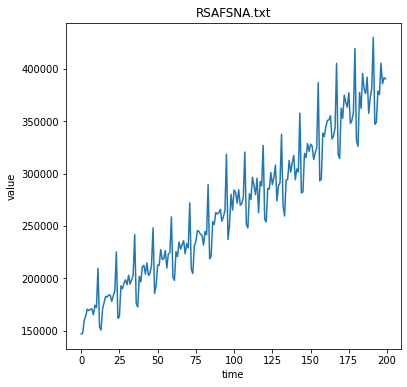

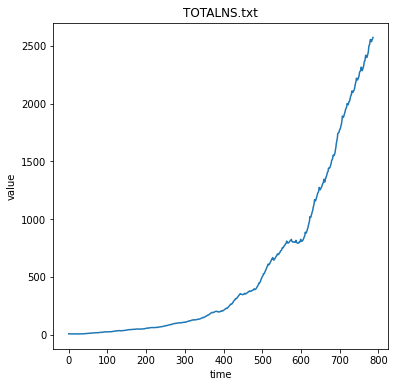

In [6]:
plt.plot(RSAFSNA)
plt.xlabel('time')
plt.ylabel('value')
plt.title('RSAFSNA.txt')
plt.show();

plt.plot(TOTALNS)
plt.xlabel('time')
plt.ylabel('value')
plt.title('TOTALNS.txt')
plt.show();

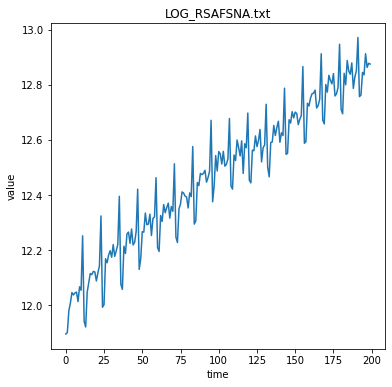

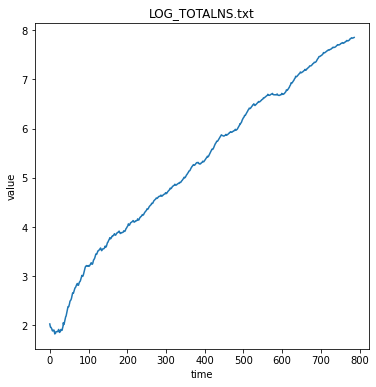

In [7]:
plt.plot(np.log1p(pd.Series(RSAFSNA)))
plt.xlabel('time')
plt.ylabel('value')
plt.title('LOG_RSAFSNA.txt')
plt.show();

plt.plot(np.log1p(pd.Series(TOTALNS)))
plt.xlabel('time')
plt.ylabel('value')
plt.title('LOG_TOTALNS.txt')
plt.show();

In [8]:
train_r, test_r = np.log1p(pd.Series(RSAFSNA[:-8])), np.log1p(pd.Series(RSAFSNA[-8:]))
train_t, test_t = np.log1p(pd.Series(TOTALNS[:-7])), np.log1p(pd.Series(TOTALNS[-7:]))

train_r.shape, test_r.shape, train_t.shape, test_t.shape

((192,), (8,), (780,), (7,))

## Trend Decompose

1


Decomposition coefs: [12.035763734237266, 0.004372286183927623]


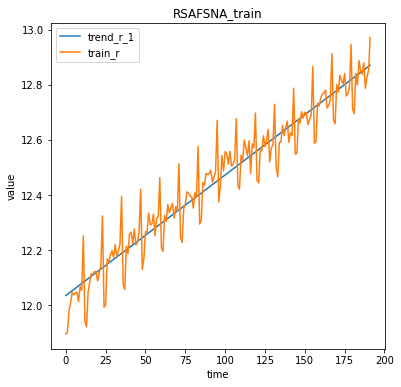

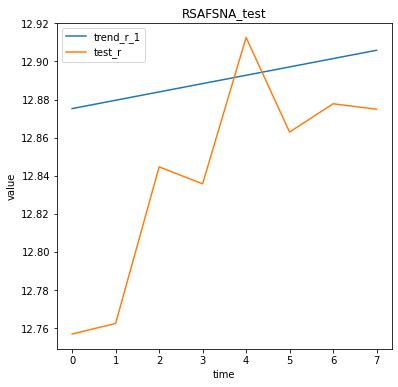

In [9]:
trend_decomposer = Trend(1)
trend_r_1 = trend_decomposer.decompose(train_r)
print('Decomposition coefs: {}'.format(trend_decomposer.coefs))
plt.title('RSAFSNA_train')
plt.plot(trend_r_1, label = 'trend_r_1')
plt.plot(train_r, label = 'train_r')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show();

plt.title('RSAFSNA_test')
plt.plot(trend_decomposer.decompose_extr(list(range(len(train_r), len(train_r)+ len(test_r)))), label = 'trend_r_1')
plt.plot(test_r.reset_index(drop=True), label = 'test_r')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show();

Decomposition coefs: [2.379611897859647, 0.007410258398697063]


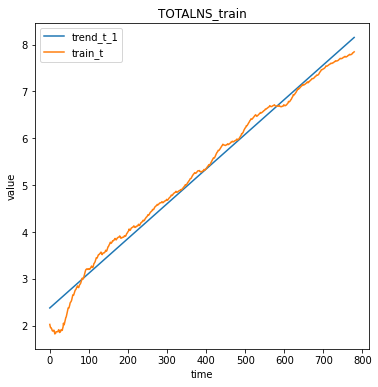

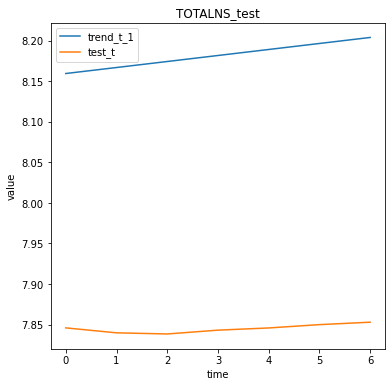

In [10]:
trend_decomposer = Trend(1)
trend_t_1 = trend_decomposer.decompose(train_t)
print('Decomposition coefs: {}'.format(trend_decomposer.coefs))
plt.title('TOTALNS_train')
plt.plot(trend_t_1, label = 'trend_t_1')
plt.plot(train_t, label = 'train_t')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show();

plt.title('TOTALNS_test')
plt.plot(trend_decomposer.decompose_extr(list(range(len(train_t), len(train_t)+ len(test_t)))), label = 'trend_t_1')
plt.plot(test_t.reset_index(drop=True), label = 'test_t')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show();

In [11]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

RSAFSNA.txt

## ARIMA

In [12]:
train_r_wt = train_r - trend_r_1

In [13]:
pacf(train_r_wt, nlags=24, method = 'ldb')

array([ 1.        ,  0.01311568, -0.20117125, -0.0295857 ,  0.00368216,
        0.13719319,  0.00912766,  0.20511357,  0.07745686,  0.02227591,
       -0.25502676, -0.05815293,  0.86789933, -0.32710839, -0.12044637,
       -0.12947035, -0.03507764, -0.13628079, -0.08374313, -0.10750509,
       -0.07543701, -0.09147372,  0.24366043,  0.00883115, -0.05776345])

In [14]:
ar_model_r = ARIMA(train_r_wt, order= ([2,7,10, 12,13, 22], 0 , 0))
ar_model_r = ar_model_r.fit()
ar_predict_r = ar_model_r.predict(0, len(train_r)+len(test_r))

In [15]:
print('ARIMA coefs:\n {}'.format(ar_model_r.params))

ARIMA coefs:
 const    -0.011630
ar.L2     0.001270
ar.L7     0.009734
ar.L10   -0.021091
ar.L12    0.934270
ar.L13   -0.033900
ar.L22   -0.011759
sigma2    0.000571
dtype: float64


In [16]:
train_r_wt_2 = train_r_wt - ar_predict_r[:len(train_r_wt)]

In [17]:
pacf(train_r_wt_2, nlags=36, method = 'ldb')

array([ 1.        ,  0.4524594 ,  0.20211156,  0.14453816, -0.03632703,
        0.13297955,  0.0761723 , -0.01409182, -0.00995555,  0.06488189,
       -0.17508822,  0.01119035,  0.01289714, -0.0302365 ,  0.01763038,
       -0.03723171, -0.11214531,  0.05965885, -0.06757807, -0.07404912,
        0.08389144, -0.08787287, -0.01064788,  0.02434575, -0.07570231,
       -0.08056704,  0.01720599, -0.03482516, -0.0351245 , -0.01669687,
       -0.08062536, -0.0272677 , -0.00274578, -0.06238392,  0.00238592,
        0.07407816,  0.00485757])

In [18]:
arima_model_r = ARIMA(train_r,order= ([2,7,10, 12,13, 22], 1 , 2))
arima_model_r = arima_model_r.fit()
arima_predict_r = arima_model_r.predict(0, len(train_r)+len(test_r))

C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [19]:
print('ARIMA coefs:\n {}'.format(arima_model_r.params))

ARIMA coefs:
 ar.L2    -0.008671
ar.L7     0.000537
ar.L10   -0.013586
ar.L12    0.960827
ar.L13   -0.007903
ar.L22    0.004782
ma.L1    -0.793792
ma.L2     0.070596
sigma2    0.000420
dtype: float64


## AR

In [20]:
pacf(train_r, nlags=24, method = 'ldb')

array([ 1.        ,  0.89417145,  0.28897385,  0.28611825,  0.16649428,
        0.13032884, -0.03200927,  0.08100972, -0.07123262, -0.05934796,
       -0.13752522,  0.12753021,  0.54209944, -0.6481847 ,  0.00422197,
        0.06009088,  0.02418304,  0.03383457, -0.01209807, -0.00772012,
        0.02896156, -0.05237394,  0.09705397,  0.01394497,  0.04163478])

In [21]:
ar_model_r = ARIMA(train_r, order= ([1, 2,3,12, 13], 0 , 0))
ar_model_r = ar_model_r.fit()
ar_predict_r = ar_model_r.predict(0, len(train_r)+len(test_r))

C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [22]:
print('ARIMA coefs:\n {}'.format(ar_model_r.params))

ARIMA coefs:
 const     12.449394
ar.L1      0.862334
ar.L2      0.027840
ar.L3      0.021645
ar.L12     0.949569
ar.L13    -0.864715
sigma2     0.000630
dtype: float64


## ARMA

In [23]:
pacf(train_r-ar_predict_r[:len(train_r)], nlags=24, method = 'ldb')

array([ 1.00000000e+00, -2.82279328e-02, -7.02848361e-02, -2.09180747e-02,
       -1.08074660e-01,  2.26446549e-03,  7.74470011e-03, -8.21392628e-03,
        2.15704027e-02,  1.32350314e-02, -1.38760408e-01, -2.20859276e-01,
        8.22022672e-04, -2.85857491e-02, -3.20634630e-02, -5.16476677e-02,
       -4.99773794e-02,  1.93257870e-02, -1.40249441e-02, -4.72743026e-02,
        4.36928492e-02, -7.60057283e-02, -1.11497858e-01,  4.98968264e-02,
       -1.35051878e-02])

In [24]:
arma_model_r = ARIMA(train_r, order= ([1, 2,3,12, 13], 0 , [11]))
arma_model_r = arma_model_r.fit()
arma_predict_r = arma_model_r.predict(0, len(train_r)+len(test_r))

C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [25]:
print('ARIMA coefs:\n {}'.format(arma_model_r.params))

ARIMA coefs:
 const     12.485394
ar.L1      0.823026
ar.L2      0.034123
ar.L3      0.007991
ar.L12     0.961350
ar.L13    -0.830353
ma.L11     0.256731
sigma2     0.000591
dtype: float64


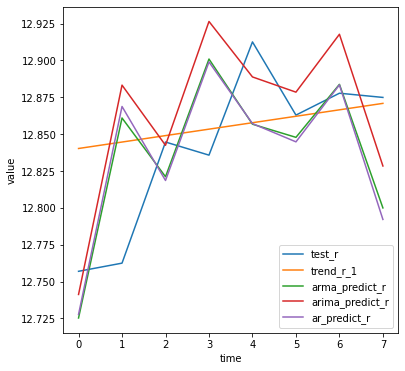

In [26]:
plt.plot(test_r, label = 'test_r')
plt.plot(trend_r_1[-8:], label = 'trend_r_1')
plt.plot(arma_predict_r[-8:].reset_index(drop = True), label = 'arma_predict_r')
plt.plot(arima_predict_r[-8:].reset_index(drop = True), label = 'arima_predict_r')
plt.plot(ar_predict_r[-8:].reset_index(drop = True), label = 'ar_predict_r')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

In [27]:
dynamic_arima_predict_r = []
for i in range(len(test_r)):
    dinamic_arima_model_r = ARIMA(list(train_r) + dynamic_arima_predict_r, order= ([2,7,10, 12,13, 22], 1 , 2))
    dinamic_arima_model_r = dinamic_arima_model_r.fit()
    temp_arima_predict_r = dinamic_arima_model_r.predict(1, len(train_r)+len(test_r))
    dynamic_arima_predict_r.append(temp_arima_predict_r[-len(test_r)+i])

C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:5

In [28]:
dynamic_ar_predict_r = []
for i in range(len(test_r)):
    dinamic_ar_model_r = ARIMA(list(train_r) + dynamic_ar_predict_r, order= ([1, 2,3,12, 13], 0 , 0))
    dinamic_ar_model_r = dinamic_ar_model_r.fit()
    temp_ar_predict_r = dinamic_ar_model_r.predict(1, len(train_r)+len(test_r))
    dynamic_ar_predict_r.append(temp_ar_predict_r[-len(test_r)+i])

C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [29]:
dynamic_arma_predict_r = []
for i in range(len(test_r)):
    dinamic_arma_model_r = ARIMA(list(train_r) + dynamic_arma_predict_r, order= ([1, 2,3,12, 13], 0 , [11]))
    dinamic_arma_model_r = dinamic_arma_model_r.fit()
    temp_arma_predict_r = dinamic_arma_model_r.predict(1, len(train_r)+len(test_r))
    dynamic_arma_predict_r.append(temp_arma_predict_r[-len(test_r)+i])

C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:5

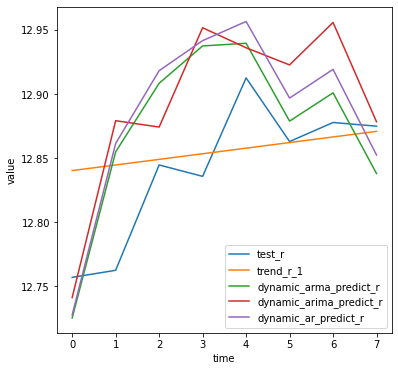

In [30]:
plt.plot(test_r, label = 'test_r')
plt.plot(trend_r_1[-8:], label = 'trend_r_1')
plt.plot(dynamic_arma_predict_r, label = 'dynamic_arma_predict_r')
plt.plot(dynamic_arima_predict_r, label = 'dynamic_arima_predict_r')
plt.plot(dynamic_ar_predict_r, label = 'dynamic_ar_predict_r')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

TOTALNS.txt

## ARIMA


In [31]:
train_t_wt = train_t - trend_t_1

In [32]:
pacf(train_t_wt, nlags=36, method = 'ldb')

array([ 1.00000000e+00,  9.94625332e-01, -1.73280702e-01, -5.44203458e-02,
       -5.34129221e-04, -7.38334715e-02, -8.55219877e-02, -1.23957493e-01,
       -3.44269341e-02, -1.05492582e-02,  3.04042251e-02,  1.84490902e-02,
       -5.99152664e-02, -2.37793701e-01, -3.73525133e-02,  7.25304447e-02,
        1.61377497e-02,  4.44434820e-02, -5.89996965e-03, -8.31159839e-03,
        4.07782709e-03, -8.77821338e-03,  2.03795463e-02,  2.40272920e-02,
       -3.31393701e-02, -1.72536550e-01, -2.30281241e-02,  6.19553413e-02,
       -9.34289725e-03, -3.21727296e-03,  3.77468305e-02, -3.19659609e-02,
        1.31684995e-02,  3.49888224e-03,  5.84754377e-02,  1.65673690e-02,
        5.39638760e-02])

In [33]:
ar_model_t = ARIMA(train_t_wt, order= ([1,13], 0 , 0))
ar_model_t = ar_model_t.fit()
ar_predict_t = ar_model_t.predict(0, len(train_t)+len(test_t))

In [34]:
train_t_wt_2 = train_t_wt - ar_predict_t[:len(train_t_wt)]

In [35]:
pacf(train_t_wt_2, nlags=60, method = 'ldb')

array([ 1.        ,  0.15804005, -0.03331275, -0.09132918,  0.02003714,
        0.01622344,  0.09461112, -0.03111658, -0.05415023, -0.09402787,
       -0.07828881,  0.04080118,  0.2792189 , -0.02307045, -0.13508466,
       -0.01535336, -0.09996568, -0.02266024, -0.020678  , -0.0233084 ,
        0.01065235, -0.04135506, -0.03069744,  0.03933371,  0.20921659,
        0.00542588, -0.06609755,  0.03948675,  0.01026785, -0.06217014,
        0.05959258, -0.01660309,  0.00930323, -0.08145723, -0.01033498,
       -0.08280747,  0.2100034 , -0.08904072, -0.04805064, -0.05058246,
        0.0199213 ,  0.02437055, -0.02778539, -0.04326074, -0.01746676,
        0.02235517,  0.01877466,  0.04557727,  0.08987275, -0.01285635,
        0.01312208, -0.05363421, -0.00662509,  0.00333703,  0.00279271,
       -0.00638563,  0.00958915, -0.00224905, -0.00915529,  0.03408559,
        0.08448344])

In [36]:
arima_model_t = ARIMA(train_t,order= ([1,13], 1 , [12,24,36]))
arima_model_t = arima_model_t.fit()
arima_predict_t = arima_model_t.predict(0, len(train_t)+len(test_t))

In [37]:
print('ARIMA coefs:\n {}'.format(arima_model_t.params))

ARIMA coefs:
 ar.L1     0.463366
ar.L13    0.078001
ma.L12    0.503749
ma.L24    0.474463
ma.L36    0.377373
sigma2    0.000071
dtype: float64


## ARMA

In [38]:
pacf(train_t, nlags=24, method = 'ldb')

array([ 1.00000000e+00,  9.96073425e-01, -1.28915565e-02, -9.14311538e-03,
       -4.45335786e-03, -7.18165066e-03, -6.18517285e-03, -1.10583610e-02,
       -7.71414095e-03, -3.88431056e-03, -1.29309031e-03, -4.50159411e-03,
       -6.89299432e-03, -1.72735701e-02, -9.82319243e-03,  3.89307514e-04,
       -3.92962403e-03,  2.02712651e-03, -3.20490472e-03, -4.67352412e-03,
       -4.22828630e-03, -3.63089964e-03, -6.59028597e-04, -2.11277397e-03,
       -3.98042310e-03])

In [39]:
ar_model_t = ARIMA(train_t, order= ([1], 0 , 0))
ar_model_t = ar_model_t.fit()
ar_predict_t = ar_model_t.predict(0, len(train_t)+len(test_t))

In [40]:
print('ARIMA coefs:\n {}'.format(ar_model_t.params))

ARIMA coefs:
 const     5.265906
ar.L1     0.999094
sigma2    0.000218
dtype: float64


In [41]:
pacf(train_t-ar_predict_t[:len(train_t)], nlags=24, method = 'ldb')

array([ 1.00000000e+00,  1.88977505e-02,  1.23518800e-02,  3.02722571e-03,
        8.66000996e-03,  9.16178358e-03,  1.48373908e-02,  8.49822551e-03,
        3.09004675e-03, -2.23442094e-03,  2.35580959e-03,  4.79307060e-03,
        2.27322268e-02,  1.33399477e-02, -3.84406508e-03,  1.49043599e-03,
       -7.36332992e-03,  2.95658871e-03,  3.57003921e-03,  2.46950177e-03,
        2.13668504e-03, -3.09619926e-03, -2.84735215e-03, -3.28390806e-04,
        1.68248802e-02])

In [42]:
arma_model_t = ARIMA(train_t, order= ([1], 0 , 0))
arma_model_t = arma_model_t.fit()
arma_predict_t = arma_model_t.predict(0, len(train_t)+len(test_t))

In [43]:
print('ARIMA coefs:\n {}'.format(arma_model_t.params))

ARIMA coefs:
 const     5.265906
ar.L1     0.999094
sigma2    0.000218
dtype: float64


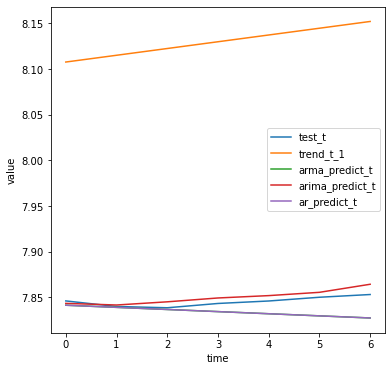

In [44]:
plt.plot(test_t, label = 'test_t')
plt.plot(trend_t_1[-7:], label = 'trend_t_1')
plt.plot(arma_predict_t[-7:].reset_index(drop = True), label = 'arma_predict_t')
plt.plot(arima_predict_t[-7:].reset_index(drop = True), label = 'arima_predict_t')
plt.plot(ar_predict_t[-7:].reset_index(drop = True), label = 'ar_predict_t')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

In [45]:
dynamic_arima_predict_t = []
for i in range(len(test_t)):
    dinamic_arima_model_t = ARIMA(list(train_t) + dynamic_arima_predict_t, order= ([1,13], 1 , [12,24,36]))
    dinamic_arima_model_t = dinamic_arima_model_t.fit()
    temp_arima_predict_t = dinamic_arima_model_t.predict(1, len(train_t)+len(test_t))
    dynamic_arima_predict_t.append(temp_arima_predict_t[-len(test_t)+i])

C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [46]:
np.round(dynamic_arima_predict_t, 5)

array([7.84323, 7.83745, 7.83686, 7.84539, 7.8556 , 7.86592, 7.88361])

In [47]:
dynamic_arma_predict_t = []
for i in range(len(test_t)):
    dinamic_arma_model_t = ARIMA(list(train_t) + dynamic_arma_predict_t, order= ([1], 0 , 0))
    dinamic_arma_model_t = dinamic_arma_model_t.fit()
    temp_arma_predict_t = dinamic_arma_model_t.predict(1, len(train_t)+len(test_t))
    dynamic_arma_predict_t.append(temp_arma_predict_t[-len(test_t)+i])

C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\valer\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [48]:
np.round(dynamic_arma_predict_t, 5)

array([7.84121, 7.83649, 7.83173, 7.82692, 7.82208, 7.81719, 7.81226])

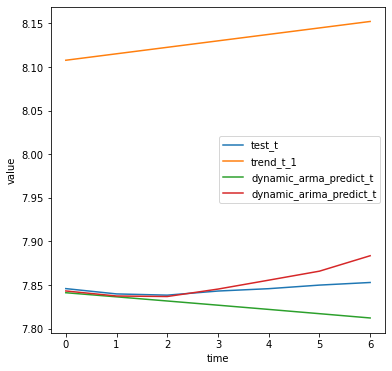

In [50]:
plt.plot(test_t, label = 'test_t')
plt.plot(trend_t_1[-7:], label = 'trend_t_1')
plt.plot(dynamic_arma_predict_t, label = 'dynamic_arma_predict_t')
plt.plot(dynamic_arima_predict_t, label = 'dynamic_arima_predict_t')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()